# Transfer learning for Melanoma Classification using EfficientNetB0


## 1. Set up

#### Set up for importing utilities

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Install efficientnet

In [2]:
import efficientnet.tfkeras as efn

 #### Random State

In [3]:
from utilities import random_state
random_state = random_state() 

#### Export Config

In [4]:
export_results = True
on_cluster = True # there is some issue with h5py in the local env but it works on cluster so w/e
export_folder = f'results/Transfer_Learning/161122-unfreeze74'

date_format = "%d%m%Y%H%M%S" # timestamp format in exported files
if export_results:
    import datetime
    import os
    if not os.path.exists(export_folder): 
      os.makedirs(export_folder)
      print("Created new directory %s" %export_folder)

#### Resolution Setup

In [5]:
img_pixel = 224 # default : 128

#### Timer

Start the timer

In [6]:
import time
start = time.time()

## 2. Get data

#### Data config

In [7]:
downsampled_data = True
base_path = "data/30" 
current_train_melanoma_percentage = 0.3

#### Get image paths
For developing models on the cluster the max_images parameter should be removed. Instead call the method get_all_img_paths(img_folder).

In [8]:
from utilities import get_all_img_paths, get_img_paths

img_folder_train = base_path + "/train" + ("_downsampled" if downsampled_data else "")
img_folder_test = base_path + "/test" + ("_downsampled" if downsampled_data else "")

max_images_train = int(13653*1)
max_images_test = int(5804*1)

img_paths_train = get_img_paths(img_folder_train, max_images_train) 
img_paths_test = get_img_paths(img_folder_test, max_images_test)

#### Load data
Loads the images specified in img_paths into a data frame. This includes resizing the images and flattening them into an array and may take a while.

In [9]:
from utilities import load_train_test

groundtruth_file_train = base_path + "/ISIC_2020_2019_train" + ("_downsampled" if downsampled_data else "") + ".csv" 
groundtruth_file_test = base_path + "/ISIC_2020_2019_test" + ("_downsampled" if downsampled_data else "") + ".csv"


# available options
options = ["sequential", # first load train, then load test
           "parallel_train_test", # load train and test parallel (load data within train and test sequential)
           "sequential_train_test_parallel_chunks", # load first train, then test, but load the data within the sets parallel
           "parallel_fusion" # run train and test parallel and parallely load data with train and test 
          ]

# chose an option
option = "parallel_fusion"

df_train, df_test = load_train_test(img_paths_train, groundtruth_file_train, 
                                    img_paths_test, groundtruth_file_test, 
                                    option, img_pixel);



Num images per thread 22
start loading train
start thread #0 for train
start loading test
start thread #0 for test
start thread #1 for train
start thread #2 for train
start thread #3 for train
start thread #4 for train
start thread #5 for train
start thread #6 for train
start thread #7 for train
start thread #8 for train
finished thread #0 for test
done loading test
finished thread #0 for train
finished thread #2 for train
finished thread #3 for train
finished thread #6 for train
finished thread #1 for train
finished thread #7 for train
finished thread #4 for train
finished thread #5 for train
finished thread #8 for train
done loading train


#### Split into target and predictors

In [10]:
from utilities import split_predictors_target

X_train, y_train = split_predictors_target(df_train) 
X_test, y_test = split_predictors_target(df_test) 

In [11]:
from utilities import unflatten_images_df

# this should rlly be optimized so that this step is no longer necessary lol
X_train = unflatten_images_df(X_train, img_pixel=img_pixel)
X_test = unflatten_images_df(X_test, img_pixel=img_pixel)

#### Delete some no longer needed data

In [12]:
import gc

del(df_train)
del(df_test)
del(img_paths_train)
del(img_paths_test)
del(img_folder_train)
del(img_folder_test)
del(groundtruth_file_train)
del(groundtruth_file_test)

gc.collect()

0

## 3. Train model

#### Util functions for training etc.

In [13]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau 
from keras.callbacks import CSVLogger

melanoma_weight = (1/current_train_melanoma_percentage)/2
class_weight = {0: 1.,
                1: melanoma_weight,}
            
def unfreeze_model(base_model, model, num_blocks = 2): # a function to unfreeze num_layers layers of a model
    # We unfreeze the nth block and all subsequent layers while leaving BatchNorm layers frozen
    for i, layer in enumerate(base_model.layers):
        if layer.name.startswith('block' + num_blocks):
            break
    freeze_from = i
    for layer in base_model.layers[freeze_from:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            
def compile_model(model, lr=0.001):
    model.compile(loss='binary_crossentropy', optimizer=Nadam(lr), metrics=['accuracy', Recall(name="recall")])
    
def fit_model(model, early_stopping, lr_scheduler):
    callbacks = [early_stopping, lr_scheduler]
    if export_results:
        filename = export_folder + "/training_log_"+datetime.datetime.now().strftime(date_format)+".csv"
        callbacks.append(CSVLogger(filename, separator=",", append=False))

    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        batch_size=32, epochs=100,
                        class_weight=class_weight,
                        callbacks=callbacks)
    return history

#### Util functions for evaluation

In [14]:
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import confusion_matrix

def eval_model(model, history, name):
    display_history(history,name)
    gc.collect()
    display_confusion_matrix(model,name)

def display_history(history, name):
    _, axs = pyplot.subplots(3, 1, figsize=(20,15))

    # plot loss during training
    axs[0].plot(history.history['loss'], label='train')
    axs[0].plot(history.history['val_loss'], label='test')
    axs[0].set_title("Loss")
    axs[0].legend()

    # plot accuracy during training
    axs[1].plot(history.history['accuracy'], label='train')
    axs[1].plot(history.history['val_accuracy'], label='test')
    axs[1].set_title("Accuracy")
    axs[1].legend()

    # plot recall during training
    axs[2].plot(history.history['recall'], label='train')
    axs[2].plot(history.history['val_recall'], label='test')
    axs[2].set_title("Recall")
    axs[2].legend()

    if export_results:
        pyplot.savefig(export_folder + "/loss_and_accuracy_during_training_"+name+"_"+datetime.datetime.now().strftime(date_format)+".png")

    pyplot.show()
    
def display_confusion_matrix(model, name):
    y_pred_continuous = model.predict(X_test)
    y_pred_discrete = (model.predict(X_test) > 0.5).astype("int32")
    y_pred = y_pred_discrete
    
    from sklearn.metrics import classification_report
    report = classification_report(y_test, y_pred, digits=4)
    print(f'\nClassification_report=\n{report}')

    if export_results:
        file = open(export_folder + "/classification_report_"+name+"_"+datetime.datetime.now().strftime(date_format)+".txt", 'w')
        file.write(report)
        file.close()
        
    class_names = ["no melanoma", "melanoma"]

    cf = confusion_matrix(y_test, y_pred)
    plot = sns.heatmap(cf, annot= True, fmt=".0f",
               xticklabels = class_names,
               yticklabels = class_names)
    plot.set(xlabel='Prediction', ylabel='Actual')

    if export_results:
        plot.get_figure().savefig(export_folder + '/confusion_matrix_' +name + "_" + datetime.datetime.now().strftime(date_format) + ".png")

#### Build model

In [15]:
import sklearn 
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
import keras
from tensorflow.keras import layers

# build model
base_model = efn.EfficientNetB0(input_shape=(img_pixel ,img_pixel , 3),weights='noisy-student',include_top=False)
base_model.trainable = False # freezing all the layers

add_model = keras.Sequential(base_model)

add_model.add(GlobalAveragePooling2D(name="avg_pool"))
add_model.add(BatchNormalization())
top_dropout_rate = 0.2
add_model.add(Dropout(top_dropout_rate, name="top_dropout"))
add_model.add(Dense(1, activation='sigmoid'))
model = add_model

gc.collect()

[<keras.engine.input_layer.InputLayer object at 0x0000029C1BE59C10>, <keras.layers.convolutional.Conv2D object at 0x0000029C141996A0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000029C14199D90>, <keras.layers.core.activation.Activation object at 0x0000029C190EC370>, <keras.layers.convolutional.DepthwiseConv2D object at 0x0000029C190B0D30>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000029C27AADA30>, <keras.layers.core.activation.Activation object at 0x0000029C190ECDC0>, <keras.layers.pooling.GlobalAveragePooling2D object at 0x0000029C14199F10>, <keras.layers.core.reshape.Reshape object at 0x0000029C22CF4C70>, <keras.layers.convolutional.Conv2D object at 0x0000029C22CF4E80>, <keras.layers.convolutional.Conv2D object at 0x0000029C22CFDF40>, <keras.layers.merge.Multiply object at 0x0000029C22CEA430>, <keras.layers.convolutional.Conv2D object at 0x0000029C22CE48B0>, <keras.layers.normalization.batch_normalization.Ba

12120

#### Train model (while still frozen)

In [16]:
# first training
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping = EarlyStopping(patience=10)
compile_model(model, lr=0.001)
history_frozen = fit_model(model, early_stopping, lr_scheduler)

Epoch 1/100
7/7 [==============================] - 34s 3s/step - loss: 1.5228 - accuracy: 0.5350 - recall: 0.6111 - val_loss: 0.5484 - val_accuracy: 0.9000 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 19s 3s/step - loss: 1.4364 - accuracy: 0.5300 - recall: 0.5833 - val_loss: 0.5847 - val_accuracy: 0.8500 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 19s 3s/step - loss: 1.2093 - accuracy: 0.5650 - recall: 0.7222 - val_loss: 0.5921 - val_accuracy: 0.8000 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 19s 3s/step - loss: 1.1438 - accuracy: 0.5700 - recall: 0.7778 - val_loss: 0.6173 - val_accuracy: 0.7500 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 20s 3s/step - loss: 1.1521 - accuracy: 0.5800 - recall: 0.7778 - val_loss: 0.6087 - val_accuracy: 0.7500 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 6/100
7/7 [=============

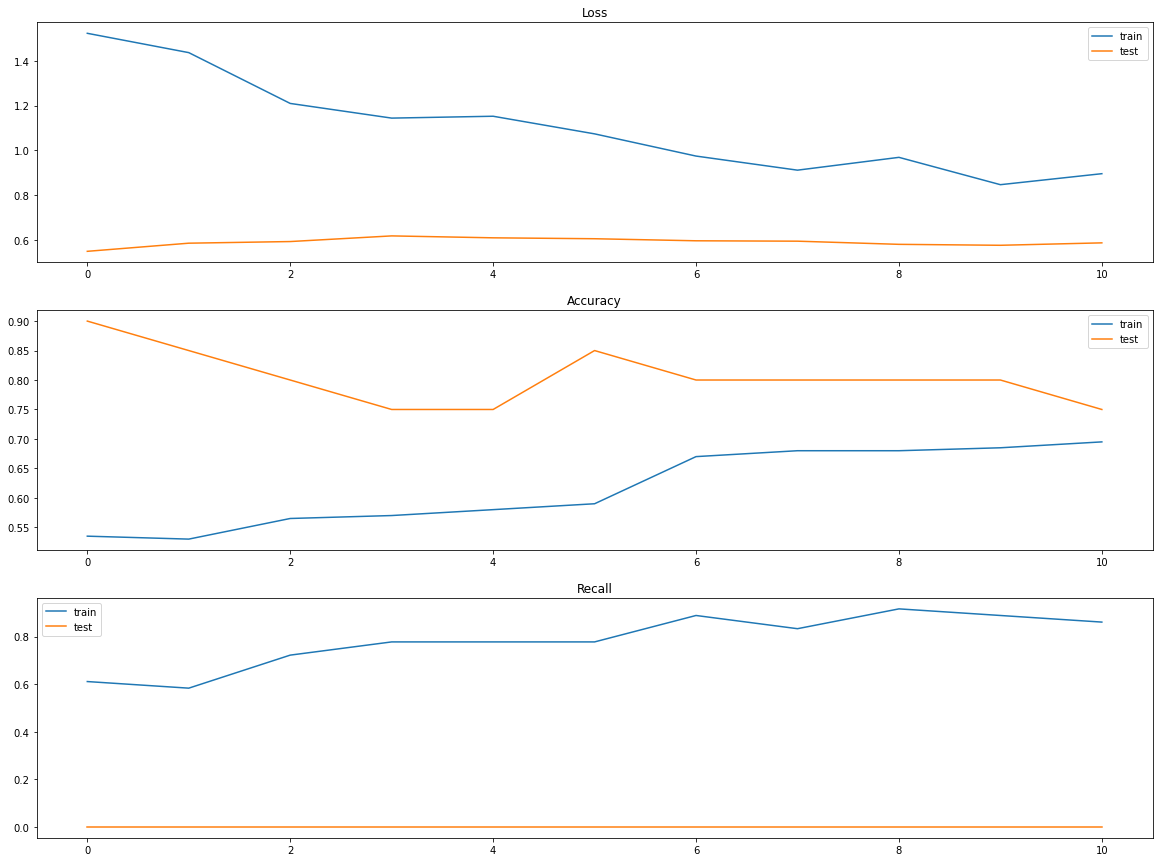


Classification_report=
              precision    recall  f1-score   support

           0     0.8824    0.8333    0.8571        18
           1     0.0000    0.0000    0.0000         2

    accuracy                         0.7500        20
   macro avg     0.4412    0.4167    0.4286        20
weighted avg     0.7941    0.7500    0.7714        20



1437

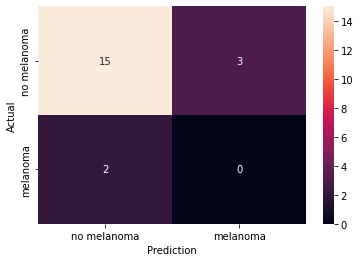

In [17]:
gc.collect()
eval_model(model, history_frozen, "frozen")
gc.collect()

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                        

#### Unfreeze and retrain

In [19]:
unfreeze_model(base_model,model,4)
print('done1')

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                   

 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_s

 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_a

 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
          

In [20]:
gc.collect()
compile_model(model, lr=0.00001) # extra low learning rate to avoid overfitting
print('done2')
gc.collect()

done2
Epoch 1/100
7/7 [==============================] - 50s 5s/step - loss: 0.9465 - accuracy: 0.6750 - recall: 0.8611 - val_loss: 0.6456 - val_accuracy: 0.6000 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
7/7 [==============================] - 29s 4s/step - loss: 0.8333 - accuracy: 0.7050 - recall: 0.8889 - val_loss: 0.6268 - val_accuracy: 0.6000 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
7/7 [==============================] - 29s 4s/step - loss: 0.6368 - accuracy: 0.7850 - recall: 1.0000 - val_loss: 0.5834 - val_accuracy: 0.6500 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/100
7/7 [==============================] - 29s 4s/step - loss: 0.5414 - accuracy: 0.7500 - recall: 1.0000 - val_loss: 0.5007 - val_accuracy: 0.8000 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/100
7/7 [==============================] - 29s 4s/step - loss: 0.5204 - accuracy: 0.7300 - recall: 0.9722 - val_loss: 0.5642 - val_accuracy: 0.8000 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoc

In [ ]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=2)
early_stopping = EarlyStopping(patience=5)
history = fit_model(model, early_stopping, lr_scheduler)

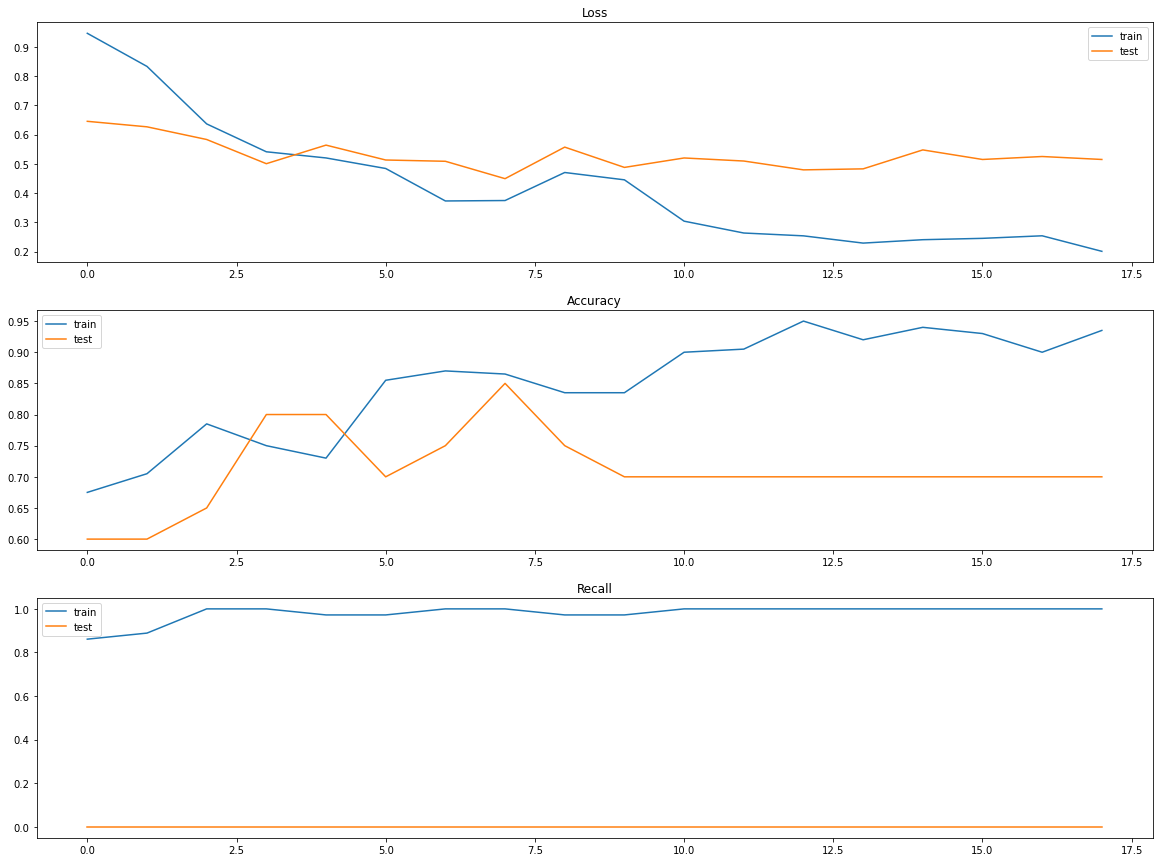


Classification_report=
              precision    recall  f1-score   support

           0     0.8750    0.7778    0.8235        18
           1     0.0000    0.0000    0.0000         2

    accuracy                         0.7000        20
   macro avg     0.4375    0.3889    0.4118        20
weighted avg     0.7875    0.7000    0.7412        20



1422

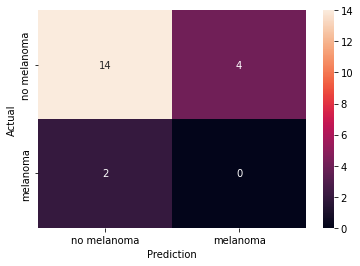

In [21]:
gc.collect()
eval_model(model, history, "unfrozen")
gc.collect()

#### Investigate final model

In [22]:
# print out model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 top_dropout (Dropout)       (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                        

In [23]:
# store model
if export_results and on_cluster:
    model.save(export_folder + "/model_"+datetime.datetime.now().strftime(date_format)+".h5")

#### Timer
Stop the timer

In [24]:
stop = time.time()
print(f'It took {stop - start} s to load the data and train the model')

if export_results:
    f = open(f'{export_folder}/overall_time.txt', 'w')
    f.write(f'Time it took : {stop - start} s')
    f.close()

It took 810.7881059646606 s to load the data and train the model


## 4. Test model

#### Predict test set (again)

In [26]:
y_pred_continuous = model.predict(X_test)
y_pred_discrete = (model.predict(X_test) > 0.5).astype("int32")
y_pred = y_pred_discrete

#### Display images and predictions

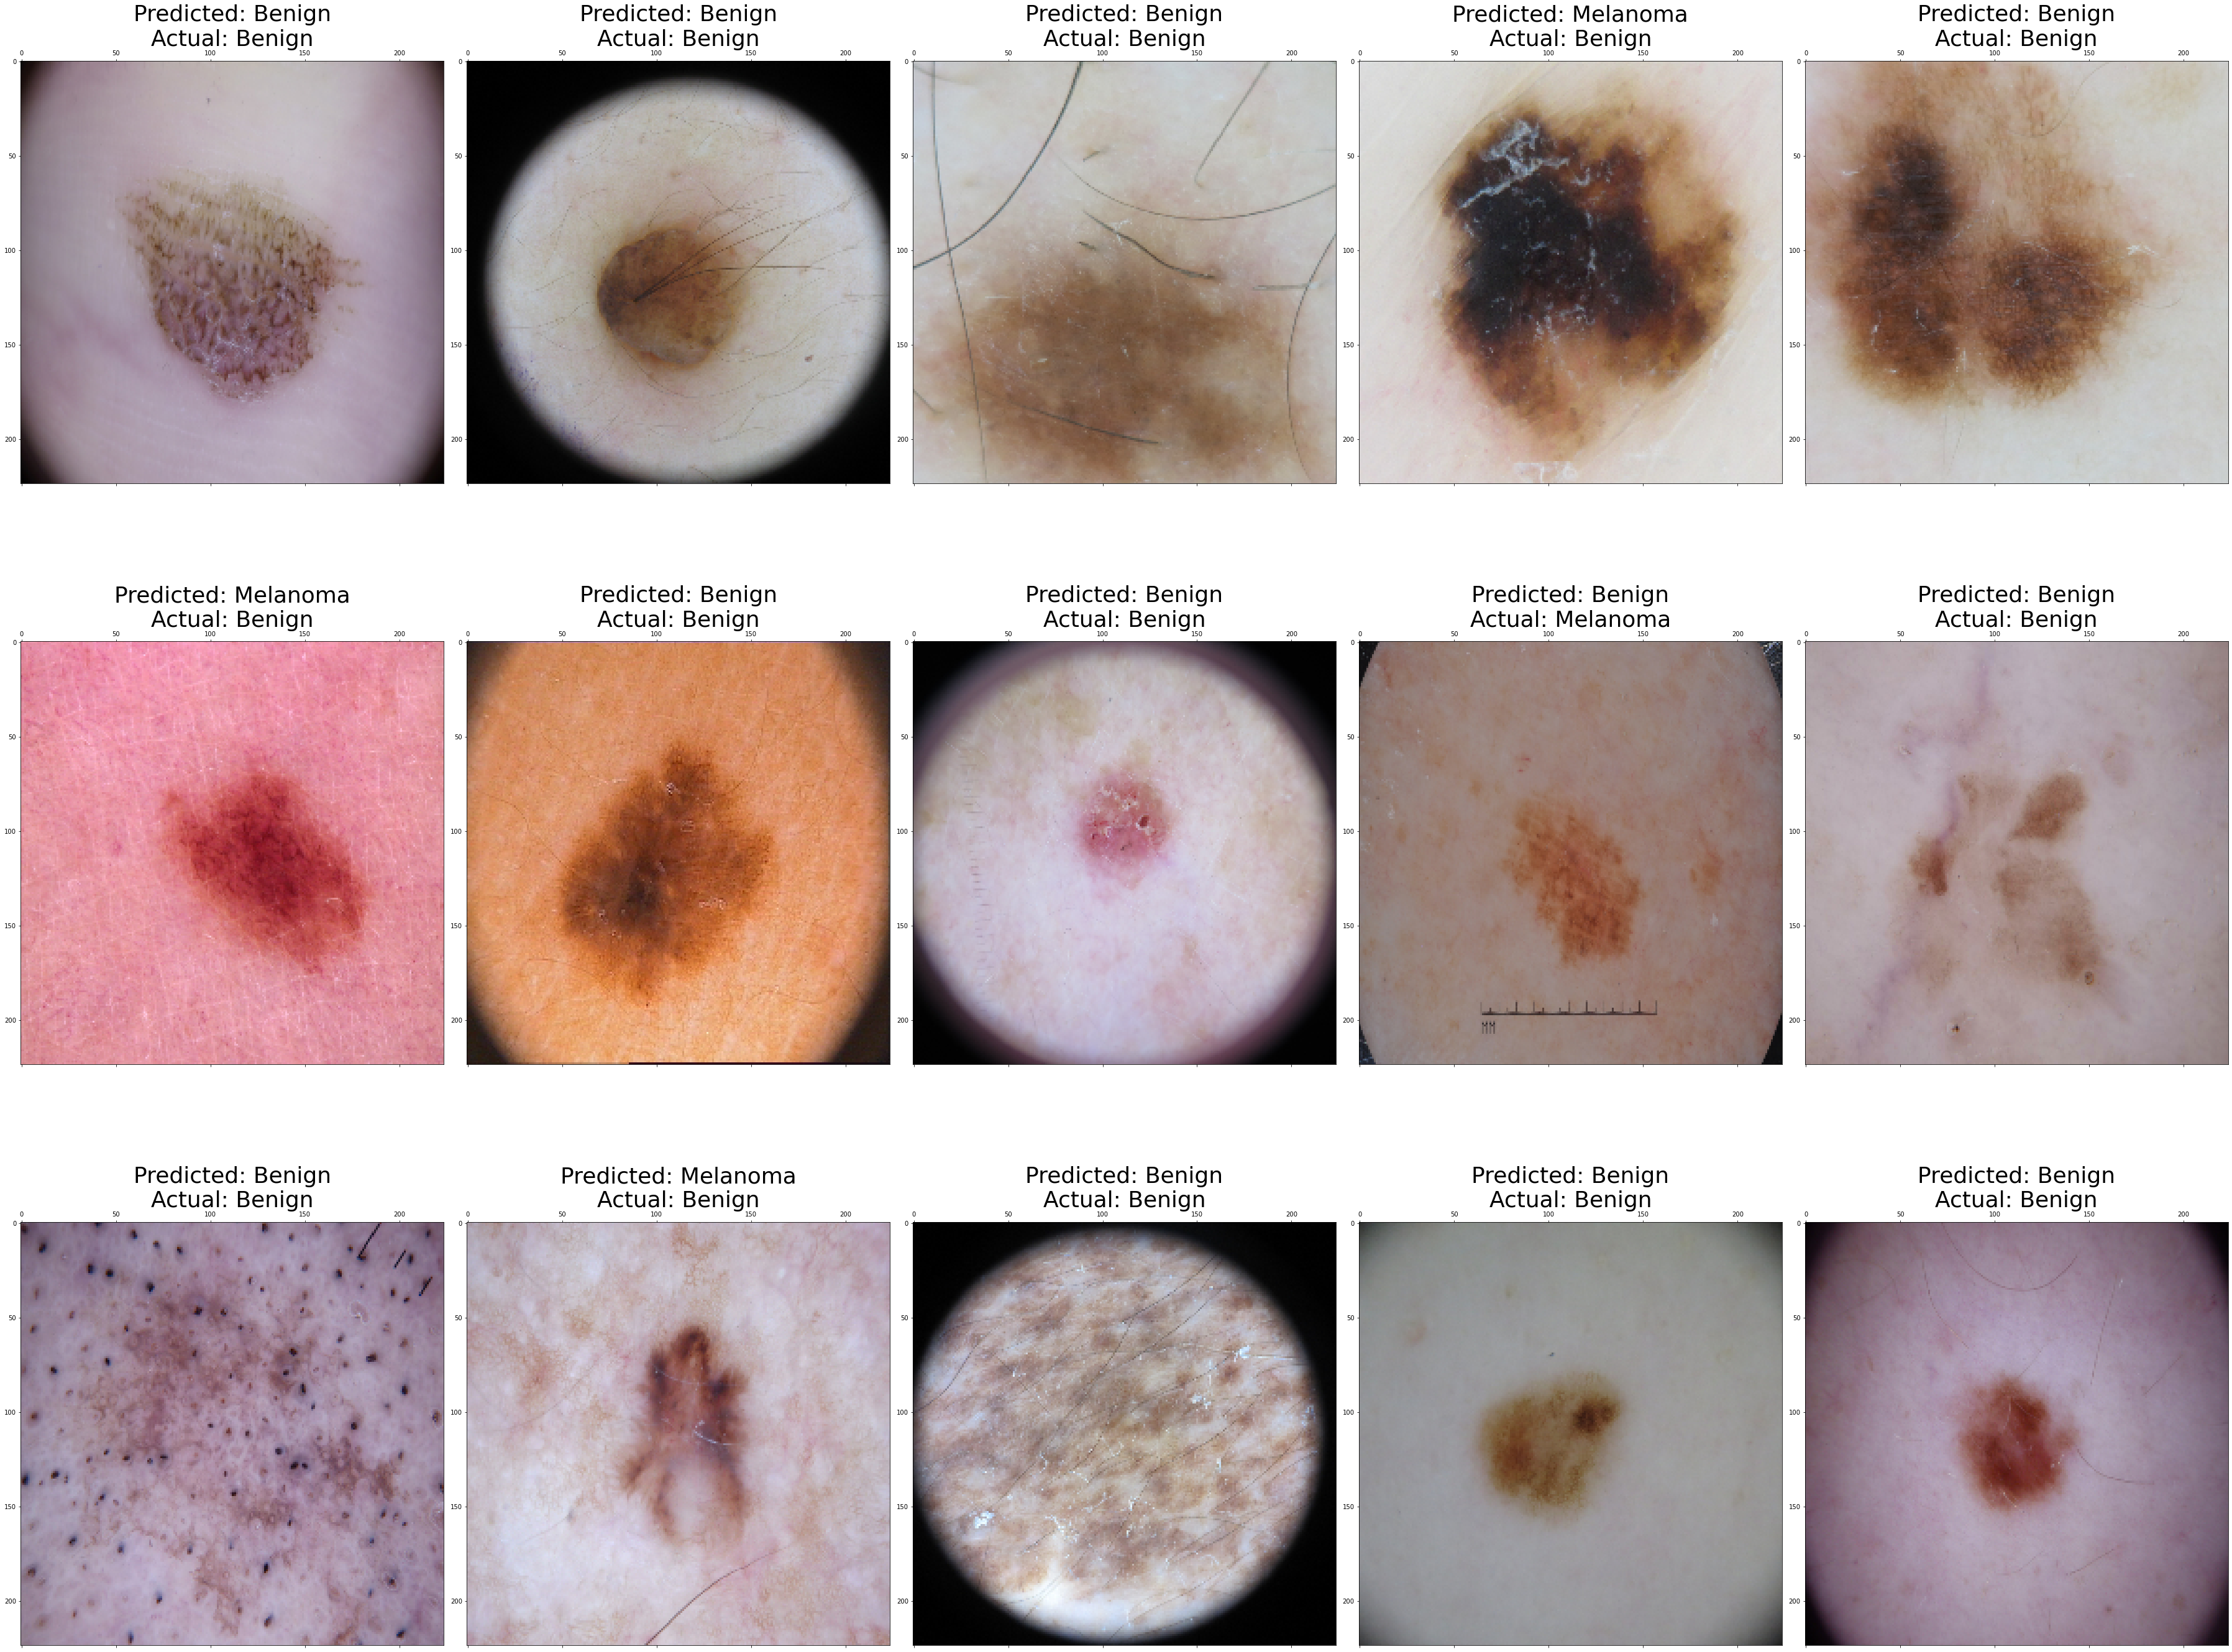

In [27]:
from utilities import display_results

plt_all = display_results(X_test, y_pred, y_test, 15, img_pixel, flat=False)

if export_results:
    plt_all.savefig(export_folder + "/classification_results_"+datetime.datetime.now().strftime(date_format)+".png")

plt_all.show()

#### Display wrongly classified images

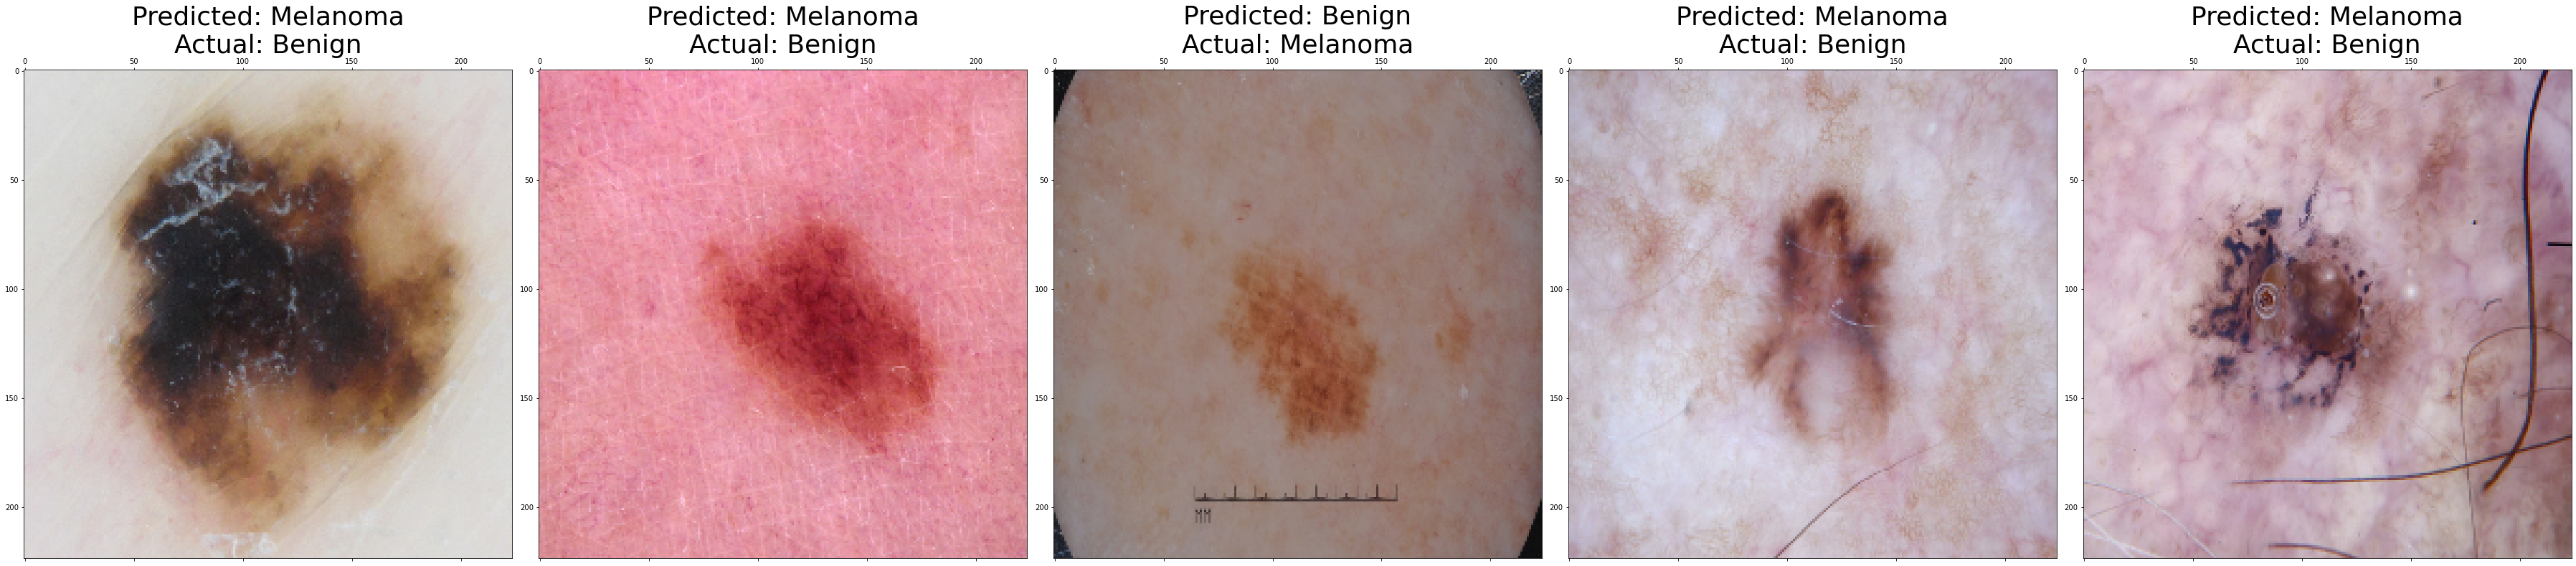

In [28]:
from utilities import display_interesting_results

plt_wrong = display_interesting_results(X_test, y_pred, y_test, img_pixel=img_pixel, flat=False)

if export_results:
    plt_wrong.savefig(export_folder + "/incorrect_classification_results_"+datetime.datetime.now().strftime(date_format)+".png")
    
plt_wrong.show()